In [227]:
import pandas as pd
import numpy as np
import seaborn as sns

In [228]:
df = pd.read_csv("../data/major_database/nifty_50_all_close_prices.csv").set_index("datetime")
print(len(df.columns))
df.head()


48


,adanient_close,adaniports_close,apollohosp_close,asianpaint_close,axisbank_close,bajajfinsv_close,bajfinance_close,bhartiartl_close,bpcl_close,britannia_close,...,sbin_close,shriramfin_close,sunpharma_close,tataconsum_close,tatasteel_close,tcs_close,techm_close,titan_close,ultracemco_close,wipro_close
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-02 09:20:00+05:30,2393.66,1197.35,6893.95,2469.60,1132.50,1573.50,652.50,1619.55,291.20,4895.00,...,834.80,610.80,1803.50,953.00,143.78,4232.40,1713.15,3230.85,11275.00,290.25
2024-12-02 09:25:00+05:30,2401.17,1202.30,6915.50,2472.60,1131.70,1572.95,650.27,1618.95,291.30,4905.00,...,838.15,610.25,1803.45,953.80,144.04,4236.45,1718.70,3235.75,11283.40,290.95
2024-12-02 09:30:00+05:30,2387.50,1196.15,6899.10,2466.80,1134.10,1571.25,650.69,1622.10,291.10,4910.75,...,836.85,611.16,1797.00,952.25,144.33,4242.25,1717.00,3236.10,11268.60,290.38
2024-12-02 09:35:00+05:30,2410.24,1205.95,6915.95,2472.20,1132.75,1576.70,652.18,1626.80,292.15,4927.00,...,840.30,615.85,1801.70,956.95,144.54,4237.75,1719.40,3249.25,11330.05,290.58
2024-12-02 09:40:00+05:30,2405.29,1207.25,6917.65,2474.15,1134.60,1579.60,652.07,1625.35,292.10,4931.20,...,841.00,616.40,1806.25,957.95,144.99,4246.00,1722.80,3259.00,11398.00,291.00


In [229]:
df.corr()

,adanient_close,adaniports_close,apollohosp_close,asianpaint_close,axisbank_close,bajajfinsv_close,bajfinance_close,bhartiartl_close,bpcl_close,britannia_close,...,sbin_close,shriramfin_close,sunpharma_close,tataconsum_close,tatasteel_close,tcs_close,techm_close,titan_close,ultracemco_close,wipro_close
adanient_close,1.000000,0.690041,0.514925,0.153366,0.642323,0.287989,0.294361,0.441212,0.650329,0.464711,...,0.499539,0.381262,0.173910,0.348163,0.461493,-0.151481,0.132650,0.437241,0.401471,-0.243198
adaniports_close,0.690041,1.000000,0.696059,0.557524,0.790243,0.709967,0.722864,0.876115,0.934384,0.854788,...,0.743201,0.684980,-0.263869,0.745061,0.849866,-0.667865,-0.234596,0.732434,0.615793,-0.687543
apollohosp_close,0.514925,0.696059,1.000000,0.604043,0.443587,0.391618,0.454272,0.638809,0.756444,0.745454,...,0.712214,0.321336,-0.161802,0.471416,0.652551,-0.488825,-0.151728,0.705053,0.826660,-0.445604
asianpaint_close,0.153366,0.557524,0.604043,1.000000,0.484787,0.431770,0.474794,0.688329,0.687059,0.570927,...,0.790503,0.660698,-0.006583,0.525539,0.563775,-0.483674,-0.371856,0.670004,0.523769,-0.486528
axisbank_close,0.642323,0.790243,0.443587,0.484787,1.000000,0.608668,0.599687,0.709205,0.779614,0.587057,...,0.737785,0.814449,0.069490,0.697902,0.627563,-0.406761,-0.178998,0.615119,0.314010,-0.588414
bajajfinsv_close,0.287989,0.709967,0.391618,0.431770,0.608668,1.000000,0.941863,0.854306,0.653114,0.816679,...,0.432344,0.616608,-0.490192,0.901397,0.706597,-0.852541,-0.598265,0.461712,0.463002,-0.817639
bajfinance_close,0.294361,0.722864,0.454272,0.474794,0.599687,0.941863,1.000000,0.864174,0.684932,0.827890,...,0.553794,0.674115,-0.500898,0.862767,0.800082,-0.872500,-0.635056,0.504608,0.429457,-0.773757
bhartiartl_close,0.441212,0.876115,0.638809,0.688329,0.709205,0.854306,0.864174,1.000000,0.883774,0.890713,...,0.717019,0.737615,-0.344661,0.873499,0.809924,-0.816215,-0.463506,0.719721,0.601770,-0.767686
bpcl_close,0.650329,0.934384,0.756444,0.687059,0.779614,0.653114,0.684932,0.883774,1.000000,0.828200,...,0.839848,0.737595,-0.138785,0.726976,0.820966,-0.658907,-0.309126,0.744517,0.646639,-0.683037
britannia_close,0.464711,0.854788,0.745454,0.570927,0.587057,0.816679,0.827890,0.890713,0.828200,1.000000,...,0.626336,0.511746,-0.469647,0.842049,0.782531,-0.802238,-0.404899,0.697967,0.712844,-0.737747


<Axes: >

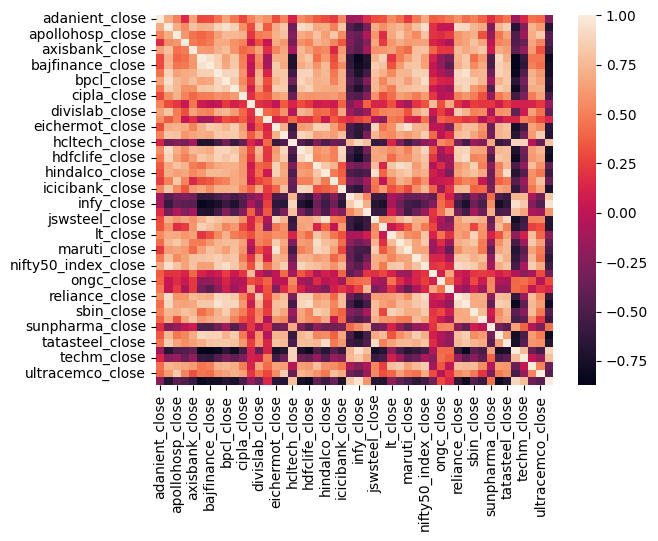

In [230]:
sns.heatmap(df.corr())

In [231]:
# compute correlation of all columns with nifty_50_index_close
corr_series = df.corr()["nifty50_index_close"]

# drop the self-correlation (1.0)
corr_series = corr_series.drop("nifty50_index_close", errors="ignore")

# print all pairs
print(corr_series.sort_values(ascending=False))


adaniports_close    0.938686
bpcl_close          0.927434
reliance_close      0.913346
hdfcbank_close      0.891007
sbilife_close       0.871311
bhartiartl_close    0.856347
grasim_close        0.851338
titan_close         0.848186
m&m_close           0.835589
sbin_close          0.834035
britannia_close     0.823989
hdfclife_close      0.804884
lt_close            0.804782
tatasteel_close     0.803439
nestleind_close     0.801105
axisbank_close      0.797625
apollohosp_close    0.797292
divislab_close      0.795589
heromotoco_close    0.773585
icicibank_close     0.737270
hindalco_close      0.716428
eichermot_close     0.713507
tataconsum_close    0.705035
jswsteel_close      0.701888
ultracemco_close    0.692018
adanient_close      0.679651
shriramfin_close    0.665399
maruti_close        0.654753
asianpaint_close    0.653598
bajfinance_close    0.647394
bajajfinsv_close    0.627331
cipla_close         0.626565
hindunilvr_close    0.580666
kotakbank_close     0.476746
drreddy_close 

In [232]:
strong_corr = corr_series[corr_series >= 0.6].to_dict()

#### Creating log returns for closing prices of stocks that have correlation > 0.6 with nifty 50

In [233]:
df_log_returns = pd.DataFrame()

In [234]:
for symbol in strong_corr.keys():
    df_log_returns[symbol] = np.log(df[symbol]/df[symbol].shift())

In [235]:
df_log_returns

,adanient_close,adaniports_close,apollohosp_close,asianpaint_close,axisbank_close,bajajfinsv_close,bajfinance_close,bhartiartl_close,bpcl_close,britannia_close,...,maruti_close,nestleind_close,reliance_close,sbilife_close,sbin_close,shriramfin_close,tataconsum_close,tatasteel_close,titan_close,ultracemco_close
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-02 09:20:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02 09:25:00+05:30,0.003133,0.004126,0.003121,0.001214,-0.000707,-0.000350,-0.003423,-0.000371,0.000343,0.002041,...,-0.002124,-0.000207,-0.002188,0.006098,0.004005,-0.000901,0.000839,0.001807,0.001515,0.000745
2024-12-02 09:30:00+05:30,-0.005709,-0.005128,-0.002374,-0.002348,0.002118,-0.001081,0.000646,0.001944,-0.000687,0.001172,...,0.002665,0.000898,0.000313,-0.002698,-0.001552,0.001490,-0.001626,0.002011,0.000108,-0.001313
2024-12-02 09:35:00+05:30,0.009480,0.008160,0.002439,0.002187,-0.001191,0.003463,0.002287,0.002893,0.003601,0.003304,...,0.001950,0.003074,0.002148,0.002249,0.004114,0.007645,0.004924,0.001454,0.004055,0.005438
2024-12-02 09:40:00+05:30,-0.002056,0.001077,0.000246,0.000788,0.001632,0.001838,-0.000169,-0.000892,-0.000171,0.000852,...,0.000664,0.001449,0.001443,-0.001141,0.000833,0.000893,0.001044,0.003108,0.002996,0.005979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28 15:10:00+05:30,-0.000877,-0.001581,0.000477,-0.001356,0.000625,-0.000287,-0.000868,0.000048,0.000836,0.000256,...,-0.000063,0.000714,-0.000447,0.000051,0.000102,0.000117,0.000086,-0.000536,-0.000332,0.000173
2025-11-28 15:15:00+05:30,0.000877,-0.000264,-0.000341,-0.000348,-0.000313,0.000334,0.000193,-0.000238,-0.000836,-0.000342,...,-0.000063,-0.000873,0.000000,-0.002187,-0.002243,-0.000645,-0.000428,-0.000596,-0.000562,-0.000259
2025-11-28 15:20:00+05:30,-0.000658,0.000066,-0.000682,0.000313,0.000000,0.000191,0.000578,-0.000666,0.000139,-0.000855,...,-0.000629,0.000159,-0.000511,0.000356,-0.000919,-0.000704,0.005296,0.000715,-0.002124,0.001121


In [236]:
df_lagged_log_returns = pd.DataFrame()

In [237]:
df_lagged_log_returns = df_log_returns.shift()

In [238]:
y = pd.DataFrame()

In [239]:
y["nifty_log_return"] = np.log(df["nifty50_index_close"]/df["nifty50_index_close"].shift())

In [240]:
y

,nifty_log_return
datetime,
2024-12-02 09:20:00+05:30,NaN
2024-12-02 09:25:00+05:30,-0.000227
2024-12-02 09:30:00+05:30,0.000096
2024-12-02 09:35:00+05:30,0.002205
2024-12-02 09:40:00+05:30,0.001162
...,...
2025-11-28 15:10:00+05:30,-0.000111
2025-11-28 15:15:00+05:30,-0.000332
2025-11-28 15:20:00+05:30,0.000053


In [241]:
df_lagged_log_returns["nifty_log_return_lag_1"] = y["nifty_log_return"].shift()

In [242]:
df_lagged_log_returns = df_lagged_log_returns.dropna(how="all")
X = df_lagged_log_returns.copy()
X

,adanient_close,adaniports_close,apollohosp_close,asianpaint_close,axisbank_close,bajajfinsv_close,bajfinance_close,bhartiartl_close,bpcl_close,britannia_close,...,nestleind_close,reliance_close,sbilife_close,sbin_close,shriramfin_close,tataconsum_close,tatasteel_close,titan_close,ultracemco_close,nifty_log_return_lag_1
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-02 09:30:00+05:30,0.003133,0.004126,0.003121,0.001214,-0.000707,-0.000350,-0.003423,-0.000371,0.000343,0.002041,...,-0.000207,-0.002188,0.006098,0.004005,-0.000901,0.000839,0.001807,0.001515,0.000745,-0.000227
2024-12-02 09:35:00+05:30,-0.005709,-0.005128,-0.002374,-0.002348,0.002118,-0.001081,0.000646,0.001944,-0.000687,0.001172,...,0.000898,0.000313,-0.002698,-0.001552,0.001490,-0.001626,0.002011,0.000108,-0.001313,0.000096
2024-12-02 09:40:00+05:30,0.009480,0.008160,0.002439,0.002187,-0.001191,0.003463,0.002287,0.002893,0.003601,0.003304,...,0.003074,0.002148,0.002249,0.004114,0.007645,0.004924,0.001454,0.004055,0.005438,0.002205
2024-12-02 09:45:00+05:30,-0.002056,0.001077,0.000246,0.000788,0.001632,0.001838,-0.000169,-0.000892,-0.000171,0.000852,...,0.001449,0.001443,-0.001141,0.000833,0.000893,0.001044,0.003108,0.002996,0.005979,0.001162
2024-12-02 09:50:00+05:30,-0.003632,-0.001865,0.000412,-0.000263,-0.001985,-0.001521,-0.000552,0.002397,0.001198,0.001257,...,-0.000510,0.001324,-0.003188,-0.001547,-0.003217,-0.001776,-0.000966,-0.001059,-0.001400,0.000203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28 15:10:00+05:30,-0.001183,-0.000263,-0.000341,-0.002083,0.001408,0.000382,0.002315,-0.000571,-0.001670,0.000085,...,0.000159,-0.000765,-0.000610,-0.000102,0.000821,0.000599,0.001489,0.001355,0.000863,-0.000015
2025-11-28 15:15:00+05:30,-0.000877,-0.001581,0.000477,-0.001356,0.000625,-0.000287,-0.000868,0.000048,0.000836,0.000256,...,0.000714,-0.000447,0.000051,0.000102,0.000117,0.000086,-0.000536,-0.000332,0.000173,-0.000111
2025-11-28 15:20:00+05:30,0.000877,-0.000264,-0.000341,-0.000348,-0.000313,0.000334,0.000193,-0.000238,-0.000836,-0.000342,...,-0.000873,0.000000,-0.002187,-0.002243,-0.000645,-0.000428,-0.000596,-0.000562,-0.000259,-0.000332


In [243]:
y = y["nifty_log_return"].dropna(how="all")
y = y.drop(df.tail(1).index)
y

datetime
2024-12-02 09:25:00+05:30   -0.000227
2024-12-02 09:30:00+05:30    0.000096
2024-12-02 09:35:00+05:30    0.002205
2024-12-02 09:40:00+05:30    0.001162
2024-12-02 09:45:00+05:30    0.000203
                               ...   
2025-11-28 15:05:00+05:30   -0.000015
2025-11-28 15:10:00+05:30   -0.000111
2025-11-28 15:15:00+05:30   -0.000332
2025-11-28 15:20:00+05:30    0.000053
2025-11-28 15:25:00+05:30    0.000031
Name: nifty_log_return, Length: 18536, dtype: float64

In [244]:
y = (y > 0).astype(int)
y

datetime
2024-12-02 09:25:00+05:30    0
2024-12-02 09:30:00+05:30    1
2024-12-02 09:35:00+05:30    1
2024-12-02 09:40:00+05:30    1
2024-12-02 09:45:00+05:30    1
                            ..
2025-11-28 15:05:00+05:30    0
2025-11-28 15:10:00+05:30    0
2025-11-28 15:15:00+05:30    0
2025-11-28 15:20:00+05:30    1
2025-11-28 15:25:00+05:30    1
Name: nifty_log_return, Length: 18536, dtype: int64

In [245]:
print(len(df_lagged_log_returns), len(y))

18536 18536


In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [247]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, shuffle=False)

#### Logistic Regression model

In [248]:
model = LogisticRegression()

In [249]:
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [250]:
accuracy_score(y_train,model.predict(X_train))

0.8629619638521716

In [251]:
accuracy_score(y_test,model.predict(X_test))

0.8446601941747572

In [253]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1783
           1       0.83      0.88      0.85      1925

    accuracy                           0.84      3708
   macro avg       0.85      0.84      0.84      3708
weighted avg       0.85      0.84      0.84      3708

